In [17]:
# Load the libraries
import spatialdata as sd
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from spatialdata import get_extent
from spatialdata import bounding_box_query
from spatialdata import match_element_to_table
import spatialdata_plot
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from datatree import DataTree
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
from sklearn.neighbors import KernelDensity
from easydecon.easydecon import *
from easydecon.config import *
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent
from mpl_toolkits.axes_grid1.inset_locator import inset_axes




pd.set_option('display.max_rows', 10)

In [18]:
%reload_ext autoreload
%autoreload 2
from easydecon.easydecon import *
from easydecon.config import *
test_function()

Easydecon loaded!
Test function executed!


In [19]:
set_n_jobs(5) #if you have more than 5 cores, you can increase this number

In [20]:
# load a compatible color map for the spatial data
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

# Loading the data and QC
Now we load the spatial data and the target data. We use 8um bin size which is an acceptable resolution. Set the sample id and point spaceranger output directory. 

You should change this based on your dataset location.

In [21]:
bin_size=8
sample_id="sampleP5"

sdata=spatialdata_io.visium_hd("../../sampleP5/binned_outputs/",fullres_image_file="../../sampleP5/binned_outputs/Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf",
                               bin_size=bin_size,dataset_id=sample_id,load_all_images=True)
sdata

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'sampleP5_cytassist_image': DataArray[cyx] (3, 3000, 3200)
│     ├── 'sampleP5_full_image': DataTree[cyx] (3, 64370, 72897), (3, 32185, 36448), (3, 16092, 18224), (3, 8046, 9112), (3, 4023, 4556)
│     ├── 'sampleP5_hires_image': DataArray[cyx] (3, 5298, 6000)
│     └── 'sampleP5_lowres_image': DataArray[cyx] (3, 530, 600)
├── Shapes
│     └── 'sampleP5_square_008um': GeoDataFrame shape: (541968, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (541968, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        sampleP5_hires_image (Images), sampleP5_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        sampleP5_lowres_image (Images), sampleP5_square_008um (Shapes)
    ▸ 'global', with elements:
        sampleP5_cytassist_image (Images), sampleP5_full_image (Images), sampleP5_square_008um (Shapes)

INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   


/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `sampleP5_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    


/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata/_core/_elements.py:116: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


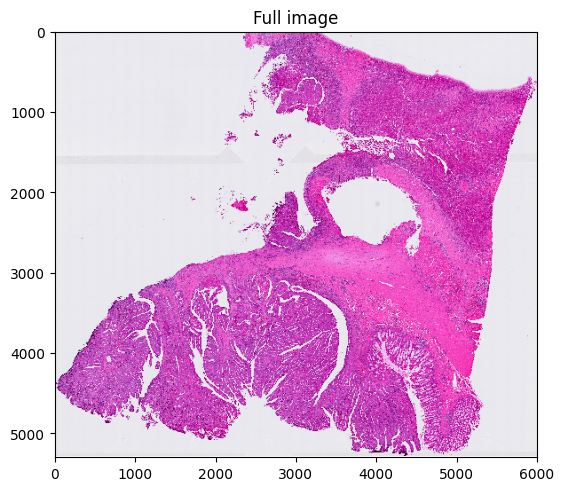

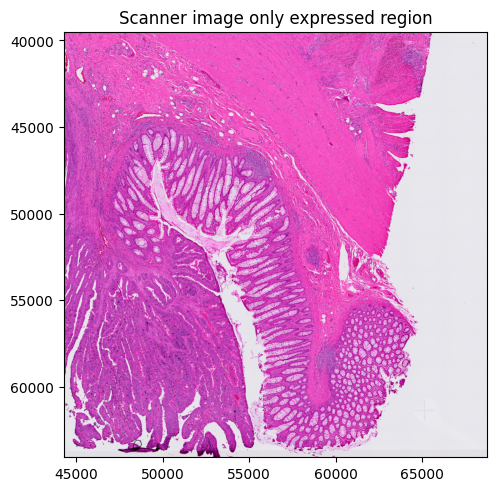

In [22]:
# to align the high resolution image with the spatial data, we need to run this part
data_extent=get_extent(sdata[f"{sample_id}_square_00{bin_size}um"])

queried_cytassist = bounding_box_query(
    sdata[f"{sample_id}_full_image"],
    min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
    max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"),
    target_coordinate_system="global",
)

sdata["queried_cytassist"]=queried_cytassist

for table in sdata.tables.values():
   table.var_names_make_unique()
   sc.pp.calculate_qc_metrics(table, inplace=True)
   sc.pp.filter_genes(table, min_cells=10)
   sc.pp.filter_cells(table, min_counts=10)
   sc.pp.normalize_total(table, inplace=True,target_sum=1e4)
   sc.pp.log1p(table)
   #sc.pp.scale(table)
   #sc.pp.pca(table)
   #sc.pp.neighbors(table)
   #sc.tl.umap(table)

#here we filter the spatial data to only include the cells that are in the table
sdata.shapes[f"{sample_id}_square_00{bin_size}um"]=sdata.shapes[f"{sample_id}_square_00{bin_size}um"][sdata.shapes[f"{sample_id}_square_00{bin_size}um"].index.isin(sdata.tables[f"square_00{bin_size}um"].obs["location_id"])]

sdata.pl.render_images(f"{sample_id}_hires_image").pl.show( title="Full image")
sdata.pl.render_images("queried_cytassist").pl.show( title="Scanner image only expressed region")

#dropping mitochondrial genes, this is optional
mt_genes = sdata.tables[f"square_00{bin_size}um"].var_names.str.startswith('MT-')
sdata.tables[f"square_00{bin_size}um"] = sdata.tables[f"square_00{bin_size}um"][:,~mt_genes]

# Read differential expression table for high level clusters.

In [23]:
#load the markers from a csv file
#"celltype" means grouping column, it is group for Scanpy, can be different for Seurat
#gene_id_column means gene ID column
#sort by scoring is a good idea.

pelka_top_level_markers_df=read_markers_dataframe(sdata,filename="../data/pelka_toplevel_deseq_table.csv",top_n_genes=60,sort_by_column="scores",celltype="group",gene_id_column="names")

pelka_top_level_markers_df.head()
#Note that this dataset contains programs which are not available in the target spatial dataset. If you have compatible dataset, it is better to use. However, this still works as intended. Only the genes available in both are kept.

Unique cell types detected in the dataframe:
['Epi' 'TNKILC' 'Plasma' 'Myeloid' 'B' 'Strom' 'Mast']


Unnamed: 0 group   names     scores  logfoldchanges  pvals  pvals_adj
group                                                                       
Epi          1518   Epi    KRT8  478.88394        7.256343    0.0        0.0
Epi          1520   Epi  LGALS4  463.74417        7.241442    0.0        0.0
Epi          1521   Epi   EPCAM  459.13583        7.299106    0.0        0.0
Epi          1522   Epi   PHGR1  454.80515        7.332155    0.0        0.0
Epi          1524   Epi  TSPAN8  437.13092        6.860310    0.0        0.0

# Phase 1 - Detect expression hotspots for high level clusters

In [24]:
#Now we will detect expression hotspots for top level markers. In this example we do a manual threshold selection.
# quantile=0.9 means that we will take the top 10% of the expression values, higher is stronger filtering.

df_cluster_sum_quantile=common_markers_gene_expression_and_filter(sdata,pelka_top_level_markers_df,filtering_algorithm="quantile",quantile=0.9,aggregation_method="sum",add_to_obs=True)


Adding results to table.obs of sdata object


In [25]:
#You will see toplevel markers are added to obs dataframe of your spatial object.
#You can directly use them for plotting.
sdata.tables[f"square_00{bin_size}um"]

AnnData object with n_obs × n_vars = 532835 × 18000
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'B', 'Epi', 'Mast', 'Myeloid', 'Plasma', 'Strom', 'TNKILC'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatialdata_attrs', 'log1p'
    obsm: 'spatial'

We visualize the expression hotspots for myeloid cells.

INFO     Using matplotlib                                                                                          


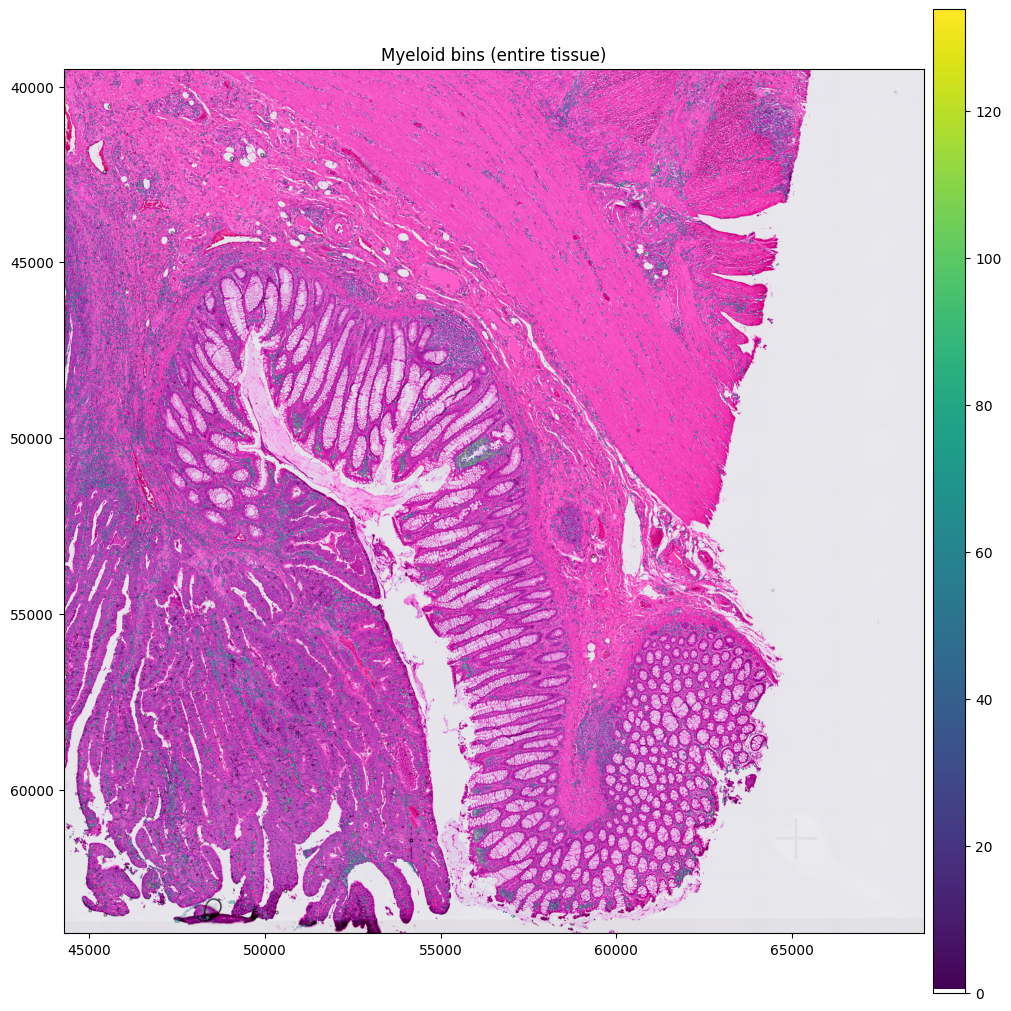

In [26]:
sdata.pl.render_images("queried_cytassist").pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="Myeloid",cmap=new_cmap,method="matplotlib",scale=0.8
        ).pl.show(coordinate_systems="global", title="Myeloid bins (entire tissue)",legend_fontsize=8,figsize=(10,10))


It is a good idea to focus a region. Lets try a region of interest. This also make everything faster.

In [27]:

sdata_small = sdata.query.bounding_box(
   min_coordinate=[48000, 51000], max_coordinate=[52000, 55000], axes=("x", "y"), target_coordinate_system="global"
)

# Phase 2 - Load mid level clusters for myeloid cells

In [28]:
pelka_mid_level_myeloid_markers_df=read_markers_dataframe(sdata_small,filename="../data/pelka_midlevel_myeloid.csv",top_n_genes=60,sort_by_column="scores",celltype="group",gene_id_column="names")

#there are four cell types here

Unique cell types detected in the dataframe:
['Macro' 'Mono' 'DC' 'Granulo']


In [29]:
#There is a column called Myeloid that , we transfer midlevel myeloid markers only these bins with enough expression
#This wont take too much time since we subset the large object

df_cluster_wjaccard=get_clusters_by_similarity_on_tissue(sdata_small,markers_df=pelka_mid_level_myeloid_markers_df,method="wjaccard",common_group_name="Myeloid")

Processing spots with Myeloid != 0
Number of threads used: 5
Batch size: 1000


100%|██████████| 3287/3287 [00:15<00:00, 207.04it/s]


Adding results to table.obs of sdata object


### Cell type assignment based on similarity

In [30]:
#We run weighted Jaccard similarity, we can directly visualize them or use them for assignment.
assign_clusters_from_df(sdata_small,df=df_cluster_wjaccard,bin_size=8,results_column=f"wjaccard_default")
#that is it, you will get a new column in the obs dataframe of your spatial object, called "wjaccard_default".

wjaccard_default
s_008um_00371_00243-1              NaN
s_008um_00383_00182-1              NaN
s_008um_00429_00238-1              NaN
s_008um_00441_00186-1              NaN
s_008um_00315_00138-1              NaN
...                                ...
s_008um_00353_00144-1              NaN
s_008um_00427_00185-1              NaN
s_008um_00432_00126-1            Macro
s_008um_00411_00261-1              NaN
s_008um_00441_00261-1              NaN

[18991 rows x 1 columns]

INFO     Using matplotlib                                                                                          


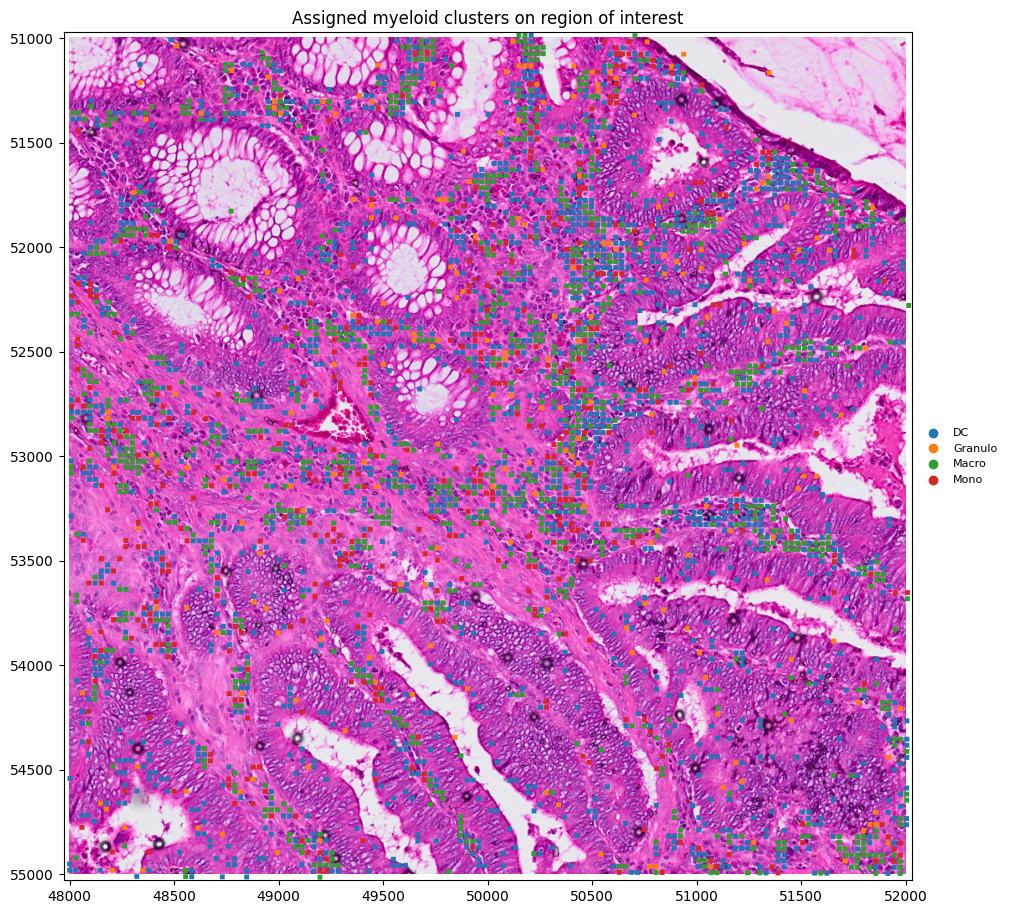

In [31]:
sdata_small.pl.render_images("queried_cytassist").pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="wjaccard_default",method="matplotlib",scale=0.8,na_color=(0.0, 0.0, 0.0, 0.0)
        ).pl.show(coordinate_systems="global", title="Assigned myeloid clusters on region of interest",legend_fontsize=8,figsize=(10,10),na_in_legend=False)


# Phase 3 - Cell type proportion estimation

In [34]:
df_cluster_mye_proportions=get_proportions_on_tissue(sdata_small,markers_df=pelka_mid_level_myeloid_markers_df,method="nnls",common_group_name="Myeloid",normalization_method="zscore")

Processing spots with Myeloid != 0
Running deconvolution with parallel processing...
Normalization method: zscore
Number of threads used: 5
Running deconvolution with method='nnls', alpha=0.1...


100%|██████████| 3287/3287 [00:04<00:00, 724.81it/s] 


Adding results to table.obs of sdata object
Deconvolution completed.


INFO     Using matplotlib                                                                                          


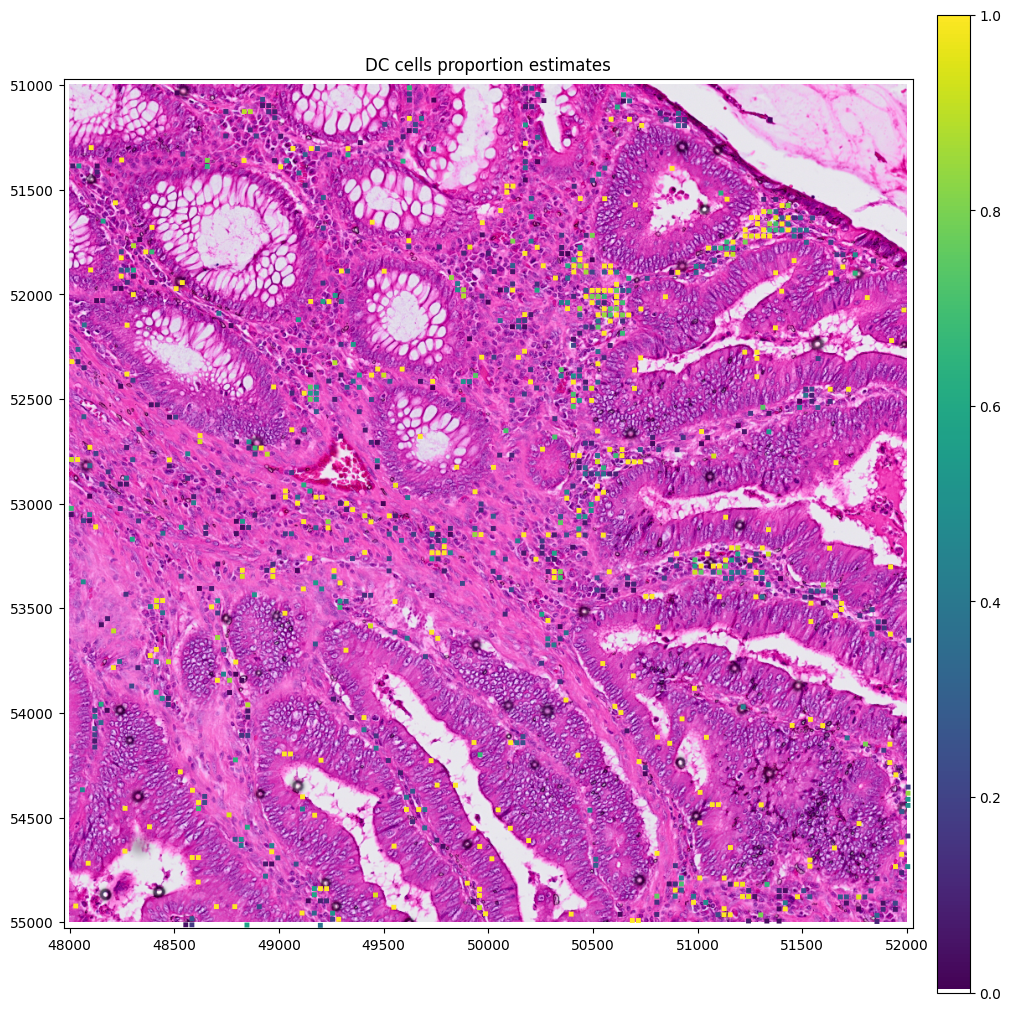

In [37]:
sdata_small.pl.render_images("queried_cytassist").pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="DC",method="matplotlib",cmap=new_cmap,scale=0.8,na_color=(0.0, 0.0, 0.0, 0.0)
        ).pl.show(coordinate_systems="global", title="DC cells proportion estimates",legend_fontsize=8,figsize=(10,10),na_in_legend=False)
